In [5]:
import code_tokenize
import re
def my_tokenizer(text):
    text = re.sub(r'\b\d+\.\d+\b', lambda x: str(float(x.group())), text)
    tokens = code_tokenize.tokenize(text, lang="c", syntax_error="ignore")
    tokens_list = [str(x) for x in tokens]
    return tokens_list

In [6]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
#pip install code-tokenize

In [8]:
# tokenize the data that can be used by embeddings
from tensorflow.keras.preprocessing.text import Tokenizer
import os
import pickle


tokenizer_path = "/home/irshad/source_code_VulDetect/diverseVulDetect/output/tokenizer/tokenizer.pkl"
retrain = False
if os.path.exists(tokenizer_path) and not retrain:
    print("[INFO] Loading saved tokenizer")
    with open(tokenizer_path, "rb") as tokenizer_file:
        tokenizer = pickle.load(tokenizer_file)
else:
    t0 = time()
    print("[INFO] fitting tokenizer on TRAIN data...")
    tokenizer = Tokenizer(lower=False, analyzer = my_tokenizer)  # used in the research paper
    tokenizer.fit_on_texts(X_train.apply(lambda x: np.str_(x)))
    # save the tokenizer for future use
    with open(tokenizer_path, "wb") as tokenizer_file:
        pickle.dump(tokenizer, tokenizer_file, protocol=pickle.HIGHEST_PROTOCOL)
        # pickle.HIGHEST_PROTOCOL is highest protocol version available
    print(f"time taken to fit and save the tokenizer: {time()-t0} s")   

[INFO] Loading saved tokenizer


In [9]:
#word2vec

In [10]:
#!pip install pandas

In [25]:
import os
import pandas as pd
# os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2



os.environ['TF_FORCE_UNIFIED_MEMORY']='1'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='2.0'
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH ']='true' # as I understood, this is redundant with the set_memory_growth part :)

import tensorflow as tf    
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      print(gpu)
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


tf.data.experimental.enable_debug_mode()
tf.config.run_functions_eagerly(True)
tf.get_logger().setLevel(tf.compat.v1.logging.DEBUG)
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Embedding, GRU, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import keras.backend as K
from keras.optimizers import Adam

import pickle
from gensim.models import Word2Vec

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val


def tokenize_sequences(X_train, X_test, X_val, tokenizer):
    X_train = [str(code) for code in X_train]  # Convert any non-string elements to string
    X_train = tokenizer.texts_to_sequences(X_train)

    X_val = [str(code) for code in X_val]  # Convert any non-string elements to string
    X_val = tokenizer.texts_to_sequences(X_val)

    X_test = [str(code) for code in X_test]  # Convert any non-string elements to string
    X_test = tokenizer.texts_to_sequences(X_test)

    max_length_train = max(len(sequence) for sequence in X_train)
    max_length_val = max(len(sequence) for sequence in X_val)
    max_length_test = max(len(sequence) for sequence in X_test)

    maxlen = 1000

    X_train = pad_sequences(X_train, padding="post", maxlen=maxlen)
    X_val = pad_sequences(X_val, padding="post", maxlen=maxlen)
    X_test = pad_sequences(X_test, padding="post", maxlen=maxlen)

    return X_train, X_val, X_test

def load_data():
    df = pd.read_csv('/home/irshad/source_code_VulDetect/diverseVulDetect/dataset/df_cleaned_preprossed.csv')
    # df_target_0 = df[df['target'] == 0].head(35000)
    # df_target_1 = df[df['target'] == 1]
    df = df.dropna()
    #df_filtered = pd.concat([df_target_0, df_target_1], ignore_index=True)
    df['target'] = df['target'].astype(int)
    X_train, X_test, y_train, y_test = train_test_split(
        df['func'],
        df['target'],
        test_size=0.20,
        random_state=42,
        stratify=df['target']
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train,
        y_train,
        test_size=0.1,
        random_state=42,
        stratify=y_train
    )

    return X_train, X_val, X_test, y_train, y_val, y_test






# def load_embedding_model(x):
#   filename = f'F://Development_//Deep Learning//Basic Dataset//BTP//1//Outputs//Embedding Models 3//Word2vec//word2vec_{x}_model.pkl'

#   with open(filename, 'rb') as f:
#     embedding_model = pickle.load(f)

#   return embedding_model
import pickle

def load_embedding_model(model_path):
    
    with open(model_path, 'rb') as f:
        word2vec_model = pickle.load(f)
    return word2vec_model



def create_model(vocab_size, embedding_dim, embedding_matrix, max_sequence_length):
    # Create an Adam optimizer with the desired learning rate
    adam_optimizer = Adam(learning_rate=0.001)
    
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False, name='LSTM_W2V_EL'))
    model.add(LSTM(units=128, return_sequences=True, name='LSTM_W2V_1', dropout=0.1))
    model.add(LSTM(units=128, name='LSTM_W2V_2'))
    model.add(Dense(units=2, activation='softmax', name='LSTM_W2V_OL'))    
    # Compile the model with the custom optimizer
    model.compile(loss='binary_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])
    
    return model


def evaluate_model(X_test_padded, y_test, model):
    y_pred_prob = model.predict(X_test_padded)  

    y_pred = np.argmax(y_pred_prob, axis=1)

    if y_test.shape[1] > 1:
        y_test = np.argmax(y_test, axis=1)

    report = classification_report(y_test, y_pred)
    print(report)

    confusion = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(confusion)


def predict_additional_data(test_padded, model):
    test_pred_prob = model.predict(test_padded)
    test_pred = (test_pred_prob > 0.5).astype(int)
    return test_pred


# def save_model(model, fold):
#     model.save(f"F://Development_//Deep Learning//Basic Dataset//BTP//1//Outputs//Checkpoints//Sentence//LSTM//Word2vec//model10k_fold_{fold}.h5")




print("1")
# Tokenize the sequences
X_train, X_val, X_test, y_train, y_val, y_test = load_data()
print("2")

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)



X_train_padded, X_val_padded, test_padded = tokenize_sequences(X_train, X_test, X_val, tokenizer)
print("3")


# embedding_dims = [50, 100 ,150]

# for embedding_dim in embedding_dims:
#     print("4")

#     embedding_model = load_embedding_model(embedding_dim)
#     print("5")

    
#     # Create the embedding matrix
#     embedding_dim = embedding_dim
#     vocab_size = 559321
#     embedding_matrix = np.zeros((vocab_size, embedding_dim))
#     for word, i in tokenizer.word_index.items():
#         if i < vocab_size and word in embedding_model.wv:
#             embedding_matrix[i] = embedding_model.wv[word]
#     print("6")
#     # Create a sequential model
#     model = create_model(vocab_size, embedding_dim, embedding_matrix, X_train_padded.shape[1])
          
    
#     history = model.fit(X_train_padded, y_train, epochs=30, batch_size=64, validation_data=(X_val_padded, y_val))

# import numpy as np
# import pickle
# import time



    
    
    


PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs
1
2


/home/irshad/anaconda3/envs/tensorflow_env/lib/python3.9/site-packages/tree_sitter/__init__.py:36: FutureWarning: Language(path, name) is deprecated. Use Language(ptr, name) instead.
  warn("{} is deprecated. Use {} instead.".format(old, new), FutureWarning)


3


In [12]:
#df = pd.read_csv('/home/irshad/source_code_VulDetect/diverseVulDetect/dataset/df_cleaned_preprossed.csv')

In [13]:
# has_nan = df['target'].isna().any()
# print(f"Contains NaN values: {has_nan}")

In [14]:
# nan_count_target = df['target'].isna().sum()
# print(f"Number of NaN values in 'target' column: {nan_count_target}")

In [26]:
def load_embedding_model(model_path):
    
    with open(model_path, 'rb') as f:
        word2vec_model = pickle.load(f)
    return word2vec_model

In [27]:
import time
import gensim
from gensim.models import Word2Vec

def create_embedding_matrix_from_pkl(pkl_filepath, word_index, embed_dim):
    """
    This function creates the embedding matrix from a pickle file.
    """
    # Load the embeddings from the pickle file
    embedding_model = load_embedding_model(pkl_filepath)
    # with open(pkl_filepath, "rb") as f:
    #     embeddings_index = pickle.load(f)

    vocab_size = len(word_index) + 1  # Adding 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embed_dim))

    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in tokenizer.word_index.items():
        if i < vocab_size and word in embedding_model.wv:
            embedding_matrix[i] = embedding_model.wv[word]

    return embedding_matrix

# Usage
t0 = time.time()
embedding_dim = 50
pkl_filepath = "/home/irshad/source_code_VulDetect/diverseVulDetect/output/embedding_models/skipGram_word2vec/word2vec_50_model.pkl"  # Update this with your actual path
embedding_matrix = create_embedding_matrix_from_pkl(pkl_filepath, tokenizer.word_index, embedding_dim)
print(f"Time taken to create embedding matrix of dimension {embedding_dim}: {time.time() - t0} s")

Time taken to create embedding matrix of dimension 50: 0.7296631336212158 s


In [28]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

577224


In [29]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Define the model checkpoint callback
model_checkpoint = ModelCheckpoint(
    filepath='/home/irshad/source_code_VulDetect/diverseVulDetect/output/models/lstm_best_model.h5', 
    monitor='val_loss', 
    save_best_only=True,
    save_weights_only=False, 
    mode='min', 
    verbose=1
)

In [ ]:
model = create_model(vocab_size, embedding_dim, embedding_matrix, X_train_padded.shape[1])

In [20]:
import tensorflow as tf

# List all physical GPUs
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    # Set memory growth for each GPU
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)


In [21]:
from tensorflow.keras import mixed_precision

# Set the global policy to mixed precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)


In [22]:
history = model.fit(X_train_padded, y_train, epochs=30, batch_size=32, validation_data=(X_val_padded, y_val), callbacks=[early_stopping, model_checkpoint])

Epoch 1/30


2024-07-21 18:36:39.526494: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


3980/3980 [==============================] - ETA: 0s - loss: 0.3383 - accuracy: 0.8946
Epoch 1: val_loss improved from inf to 0.33328, saving model to /home/irshad/source_code_VulDetect/diverseVulDetect/output/models/lstm_best_model.h5
3980/3980 [==============================] - 1045s 262ms/step - loss: 0.3383 - accuracy: 0.8946 - val_loss: 0.3333 - val_accuracy: 0.8962
Epoch 2/30
3980/3980 [==============================] - ETA: 0s - loss: 0.3339 - accuracy: 0.8961
Epoch 2: val_loss did not improve from 0.33328
3980/3980 [==============================] - 1052s 264ms/step - loss: 0.3339 - accuracy: 0.8961 - val_loss: 0.3333 - val_accuracy: 0.8960
Epoch 3/30
3980/3980 [==============================] - ETA: 0s - loss: 0.2727 - accuracy: 0.9165
Epoch 3: val_loss improved from 0.33328 to 0.17474, saving model to /home/irshad/source_code_VulDetect/diverseVulDetect/output/models/lstm_best_model.h5
3980/3980 [==============================] - 1102s 277ms/step - loss: 0.2727 - accuracy: 0.9

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM_W2V_EL (Embedding)     (None, 3000, 50)          28861200  
                                                                 
 LSTM_W2V_1 (LSTM)           (None, 3000, 128)         91648     
                                                                 
 LSTM_W2V_2 (LSTM)           (None, 128)               131584    
                                                                 
 LSTM_W2V_OL (Dense)         (None, 2)                 258       
                                                                 
Total params: 29,084,690
Trainable params: 223,490
Non-trainable params: 28,861,200
_________________________________________________________________


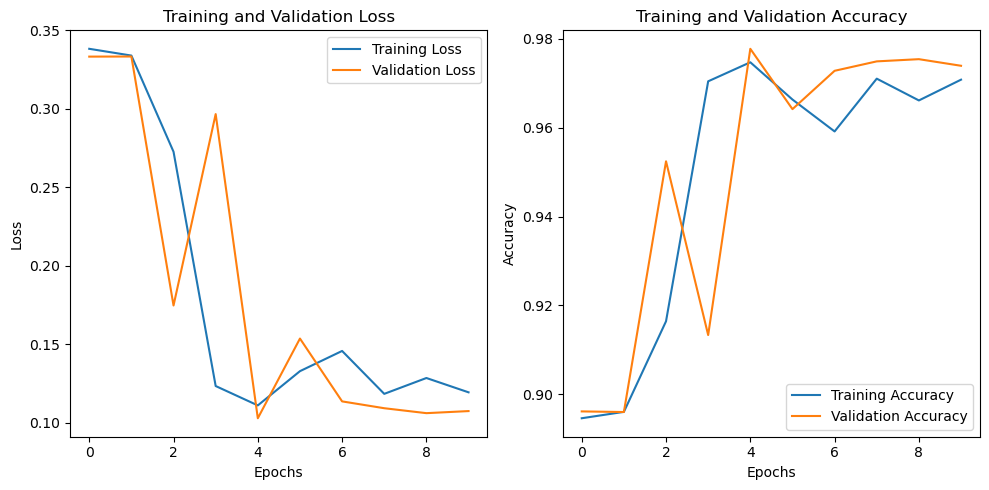

1106/1106 [==============================] - 97s 88ms/step
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     31584
           1       1.00      0.78      0.87      3789

    accuracy                           0.98     35373
   macro avg       0.99      0.89      0.93     35373
weighted avg       0.98      0.98      0.97     35373

Confusion Matrix:
[[31583     1]
 [  852  2937]]


In [23]:
# Plot both loss and accuracy
plt.figure(figsize=(10, 5))  # Adjust figure size as desired
plt.subplot(1, 2, 1)  # Create subplot for loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
    
plt.subplot(1, 2, 2)  # Create subplot for accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()  # Adjust spacing between subplots
plt.show()
# Evaluate the model using the test set
evaluate_model(test_padded, y_test, model)

# Predict on the additional test set
# test_pred = predict_additional_data(test_padded, model)    

In [ ]:
model.save(f"F://Development_//Deep Learning//Basic Dataset//BTP//1//Outputs//Models//LSTM//word2vec 3/LSTM_w2v_{embedding_dim}.keras")
    

# FastText

In [ ]:
import os
import pandas as pd
# os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2



os.environ['TF_FORCE_UNIFIED_MEMORY']='1'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='2.0'
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH ']='true' # as I understood, this is redundant with the set_memory_growth part :)

import tensorflow as tf    
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      print(gpu)
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


tf.data.experimental.enable_debug_mode()
tf.config.run_functions_eagerly(True)
tf.get_logger().setLevel(tf.compat.v1.logging.DEBUG)
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Embedding, GRU, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import keras.backend as K
from keras.optimizers import Adam

import pickle
from gensim.models import Word2Vec

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val


def tokenize_sequences(X_train, X_test, X_val, tokenizer):
    X_train = [str(code) for code in X_train]  # Convert any non-string elements to string
    X_train = tokenizer.texts_to_sequences(X_train)

    X_val = [str(code) for code in X_val]  # Convert any non-string elements to string
    X_val = tokenizer.texts_to_sequences(X_val)

    X_test = [str(code) for code in X_test]  # Convert any non-string elements to string
    X_test = tokenizer.texts_to_sequences(X_test)

    max_length_train = max(len(sequence) for sequence in X_train)
    max_length_val = max(len(sequence) for sequence in X_val)
    max_length_test = max(len(sequence) for sequence in X_test)

    maxlen = 1000

    X_train = pad_sequences(X_train, padding="post", maxlen=maxlen)
    X_val = pad_sequences(X_val, padding="post", maxlen=maxlen)
    X_test = pad_sequences(X_test, padding="post", maxlen=maxlen)

    return X_train, X_val, X_test

def load_data():
    df = pd.read_csv('F://Development_//Deep Learning//Basic Dataset//BTP//1//Dataset//CSVs//preprocessed_df_100k.csv')
    df_target_0 = df[df['target'] == 0].head(35000)
    df_target_1 = df[df['target'] == 1]
    
    df_filtered = pd.concat([df_target_0, df_target_1], ignore_index=True)
    
    X_train, X_test, y_train, y_test = train_test_split(
        df_filtered['func'],
        df_filtered['target'],
        test_size=0.1,
        random_state=42,
        stratify=df_filtered['target']
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train,
        y_train,
        test_size=0.1,
        random_state=42,
        stratify=y_train
    )

    return X_train, X_val, X_test, y_train, y_val, y_test






def load_embedding_model(x):
  filename = f'F://Development_//Deep Learning//Basic Dataset//BTP//1//Outputs//Embedding Models 3//FastText//fasttext_{x}_model.pkl'

  with open(filename, 'rb') as f:
    embedding_model = pickle.load(f)

  return embedding_model


def create_model(vocab_size, embedding_dim, embedding_matrix, max_sequence_length):
    # Create an Adam optimizer with the desired learning rate
    adam_optimizer = Adam(learning_rate=0.001)
    
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False, name='LSTM_W2V_EL'))
    model.add(LSTM(units=128, return_sequences=True, name='LSTM_W2V_1', dropout=0.1))
    model.add(LSTM(units=128, name='LSTM_W2V_2'))
    model.add(Dense(units=2, activation='softmax', name='LSTM_W2V_OL'))    
    # Compile the model with the custom optimizer
    model.compile(loss='binary_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])
    
    return model


def evaluate_model(X_test_padded, y_test, model):
    y_pred_prob = model.predict(X_test_padded)  

    y_pred = np.argmax(y_pred_prob, axis=1)

    if y_test.shape[1] > 1:
        y_test = np.argmax(y_test, axis=1)

    report = classification_report(y_test, y_pred)
    print(report)

    confusion = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(confusion)


def predict_additional_data(test_padded, model):
    test_pred_prob = model.predict(test_padded)
    test_pred = (test_pred_prob > 0.5).astype(int)
    return test_pred


def save_model(model, fold):
    model.save(f"F://Development_//Deep Learning//Basic Dataset//BTP//1//Outputs//Checkpoints//Sentence//LSTM//Word2vec//model10k_fold_{fold}.h5")




print("1")
# Tokenize the sequences
X_train, X_val, X_test, y_train, y_val, y_test = load_data()
print("2")

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)



X_train_padded, X_val_padded, test_padded = tokenize_sequences(X_train, X_test, X_val, tokenizer)
print("3")


embedding_dims = [50, 100 ,150]

for embedding_dim in embedding_dims:
    print("4")

    embedding_model = load_embedding_model(embedding_dim)
    print("5")

    
    # Create the embedding matrix
    embedding_dim = embedding_dim
    vocab_size = 559321
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in tokenizer.word_index.items():
        if i < vocab_size and word in embedding_model.wv:
            embedding_matrix[i] = embedding_model.wv[word]
    print("6")
    # Create a sequential model
    model = create_model(vocab_size, embedding_dim, embedding_matrix, X_train_padded.shape[1])
          
    
    history = model.fit(X_train_padded, y_train, epochs=30, batch_size=64, validation_data=(X_val_padded, y_val))
    
    # Plot both loss and accuracy
    plt.figure(figsize=(10, 5))  # Adjust figure size as desired
    plt.subplot(1, 2, 1)  # Create subplot for loss
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
        
    plt.subplot(1, 2, 2)  # Create subplot for accuracy
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()
    # Evaluate the model using the test set
    evaluate_model(test_padded, y_test, model)
    
    # Predict on the additional test set
    # test_pred = predict_additional_data(test_padded, model)        
        
    model.save(f"F://Development_//Deep Learning//Basic Dataset//BTP//1//Outputs//Models//LSTM//word2vec 3/LSTM_ft_{embedding_dim}.keras")
    